# Energy Demand Forecasting

In [1]:
# Requirments.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
%matplotlib inline

## Display all columns
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [2]:
path = r"C:\Users\ameya\GitHub\EnergyDemandForecasting_TimeSeriesAnalysis\Dataset\historic_demand_2009_2022.csv"
df_energy = pd.read_csv(path)

In [3]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243936 entries, 0 to 243935
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 243936 non-null  int64  
 1   settlement_date            243936 non-null  object 
 2   settlement_period          243936 non-null  int64  
 3   nd                         243936 non-null  int64  
 4   tsd                        243936 non-null  int64  
 5   england_wales_demand       243936 non-null  int64  
 6   embedded_wind_generation   243936 non-null  int64  
 7   embedded_wind_capacity     243936 non-null  int64  
 8   embedded_solar_generation  243936 non-null  int64  
 9   embedded_solar_capacity    243936 non-null  int64  
 10  non_bm_stor                243936 non-null  int64  
 11  pump_storage_pumping       243936 non-null  int64  
 12  ifa_flow                   243936 non-null  int64  
 13  ifa2_flow                  24

In [4]:
df_energy.head()

,Unnamed: 0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1


In [4]:
print( 'PREDICTORS =', df_energy.shape[1] )
print( 'SAMPLES =', df_energy.shape[0] )

PREDICTORS = 21
SAMPLES = 243936


## Data Cleaning

In [5]:
FEATURES_NaN = [feature for feature in df_energy.columns if df_energy[feature].isnull().sum() >= 1]
print( FEATURES_NaN )

['nsl_flow', 'eleclink_flow']


In [6]:
PERCENT_NULL = np.round( df_energy.isnull().mean(), 2 )
print( PERCENT_NULL )

Unnamed: 0                   0.00
settlement_date              0.00
settlement_period            0.00
nd                           0.00
tsd                          0.00
england_wales_demand         0.00
embedded_wind_generation     0.00
embedded_wind_capacity       0.00
embedded_solar_generation    0.00
embedded_solar_capacity      0.00
non_bm_stor                  0.00
pump_storage_pumping         0.00
ifa_flow                     0.00
ifa2_flow                    0.00
britned_flow                 0.00
moyle_flow                   0.00
east_west_flow               0.00
nemo_flow                    0.00
nsl_flow                     0.72
eleclink_flow                0.72
is_holiday                   0.00
dtype: float64


In [7]:
df = df_energy.copy()

# Dropping columns with Null values
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [8]:
# Dates where respone is zero, that is Bogus Data (needs to be removed)
zero_response = list( df[df['tsd']==0.0]['settlement_date'].unique() )
index_with_zero_response = []
for day in zero_response:
    index_with_zero_response.append(df[df["settlement_date"] == day].index.tolist())
index_with_zero_response = [item for sublist in index_with_zero_response for item in sublist]
df.drop(index=index_with_zero_response, inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
import holidays
bank_holiday_england = holidays.UK(
                                    subdiv="England", 
                                    years=range(2009, 2024), 
                                    observed=True
                                    ).items()

## Feature Engineering

In [10]:
# Adding hours to settlement date
import datetime

df["period_hour"] = (df["settlement_period"]).apply( lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5)) )
df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)
df["settlement_date"] = pd.to_datetime( (df["settlement_date"] + " " + df["period_hour"]) )

df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

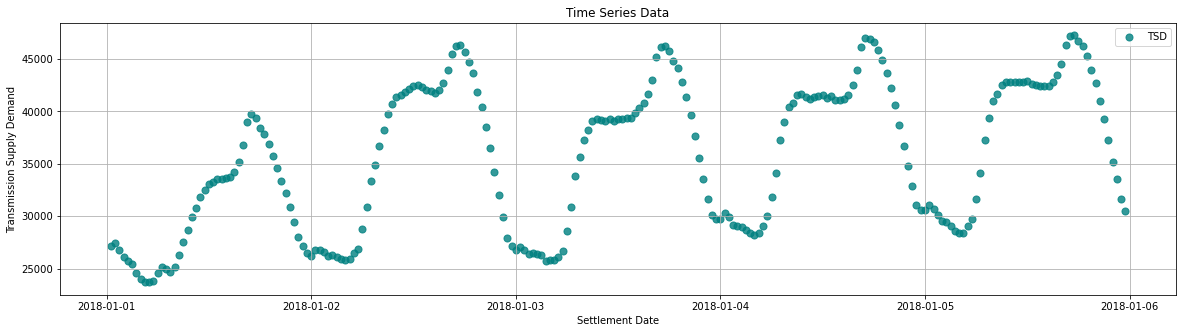

In [11]:
# Plotting Weekly Data

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.scatter(df.loc[(df.index > "01-01-2018") & (df.index < "01-06-2018")]["tsd"].index,
            df.loc[(df.index > "01-01-2018") & (df.index < "01-06-2018")]["tsd"],
           marker = 'o',
           c = 'teal',
           s = 50,
           alpha=0.8,
           label="TSD"
           )

plt.title('Time Series Data')
plt.xlabel('Settlement Date')
plt.ylabel('Transmission Supply Demand')
plt.grid(True); plt.legend(); plt.show()

In [12]:
# Adding New Features by Seperating Date, Month, Year, Hour etc.
df["day_of_month"] = df.index.day
df["day_of_week"] = df.index.day_of_week
df["day_of_year"] = df.index.day_of_year
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["year"] = df.index.year
df["week_of_year"] = df.index.isocalendar().week.astype("int64")

In [13]:
# Adding yearly Lags
target_map = df["tsd"].to_dict()
df["lag_1y"] = (df.index - pd.Timedelta("364 days")).map(target_map)
df["lag_2y"] = (df.index - pd.Timedelta("728 days")).map(target_map)
df["lag_3y"] = (df.index - pd.Timedelta("1092 days")).map(target_map)

## Exploratory Data Analysis

In [14]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.scatter(df_eda.index,
           df_eda['tsd'],
           marker = '.',
           c = 'teal',
           s = 1,
           alpha=0.8,
           label="TSD"
           )

plt.scatter(df_eda[df_eda["is_holiday"] == 1]['is_holiday'].index,
            df_eda[df_eda["is_holiday"] == 1]['is_holiday'] * 35000,
            marker = '.',
            c = 'k',
            label="Bank holiday"
            )

plt.title('Time Series Data')
plt.xlabel('Settlement Date')
plt.ylabel('Transmission Supply Demand')
plt.grid(True); plt.legend(); plt.show()

NameError: name 'df_eda' is not defined

<Figure size 1440x360 with 0 Axes>

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243188 entries, 2009-01-01 00:00:00 to 2022-11-30 23:30:00
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 243188 non-null  int64  
 1   period_hour                243188 non-null  object 
 2   settlement_period          243188 non-null  int64  
 3   nd                         243188 non-null  int64  
 4   tsd                        243188 non-null  int64  
 5   england_wales_demand       243188 non-null  int64  
 6   embedded_wind_generation   243188 non-null  int64  
 7   embedded_wind_capacity     243188 non-null  int64  
 8   embedded_solar_generation  243188 non-null  int64  
 9   embedded_solar_capacity    243188 non-null  int64  
 10  non_bm_stor                243188 non-null  int64  
 11  pump_storage_pumping       243188 non-null  int64  
 12  ifa_flow                   243188 non-null  int64  


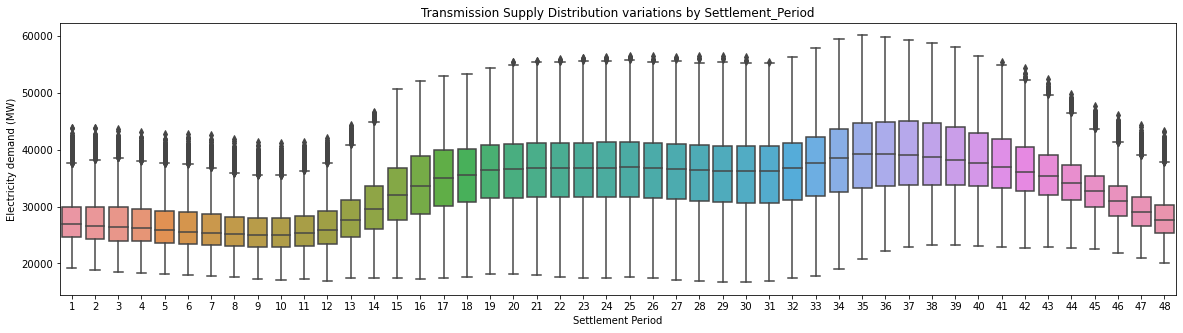

In [212]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df,
            x="settlement_period", 
            y="tsd", 
            )
ax.set_xticks(range(0, 48))
ax.set_xticklabels(range(1, 49))
ax.set_xlabel("Settlement Period")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Transmission Supply Distribution variations by Settlement_Period");

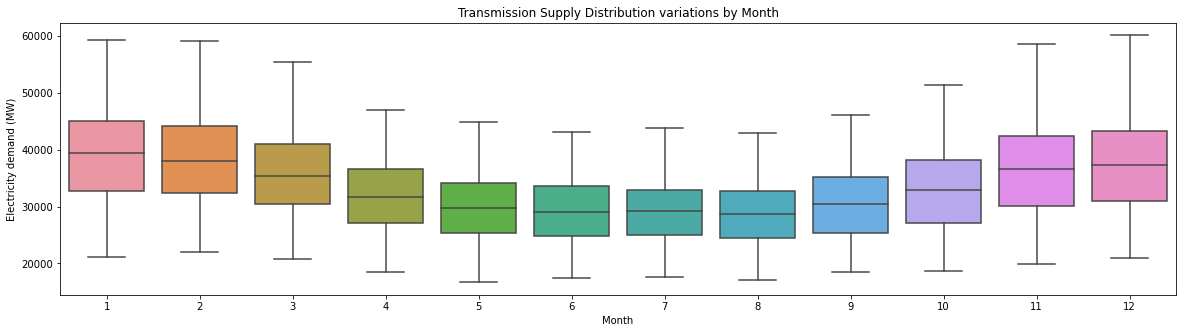

In [218]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df,
            x="month", 
            y="tsd",
            )

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Transmission Supply Distribution variations by Month");

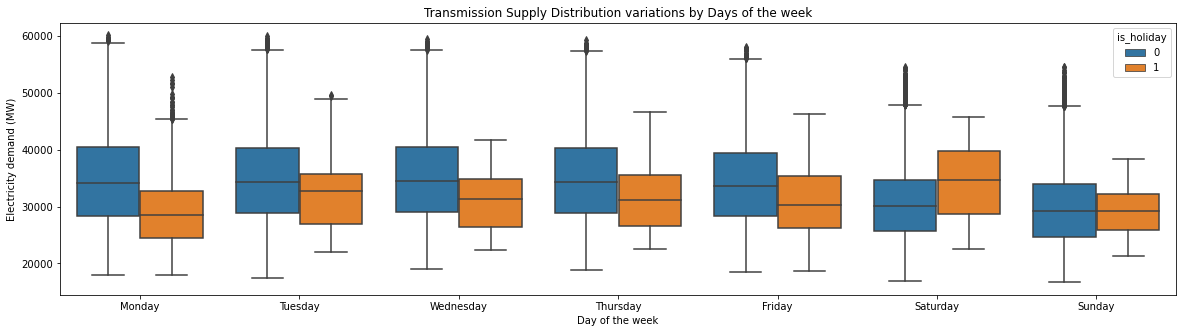

In [220]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df,
            x="day_of_week", 
            y="tsd",
            hue="is_holiday", 
            ax=ax)

ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Transmission Supply Distribution variations by Days of the week");

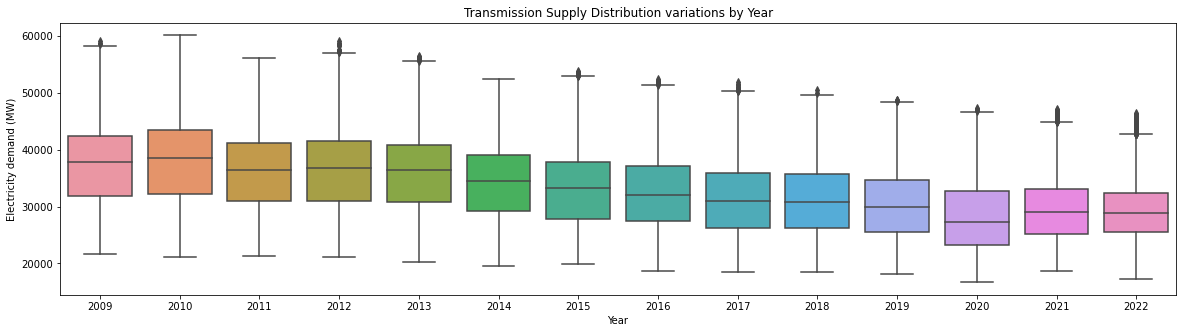

In [221]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df,
            x="year",
             y="tsd", )

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Transmission Supply Distribution variations by Year");

## Model Developemnt

In [15]:
# Storing original Dataframe
df_org = df.copy()

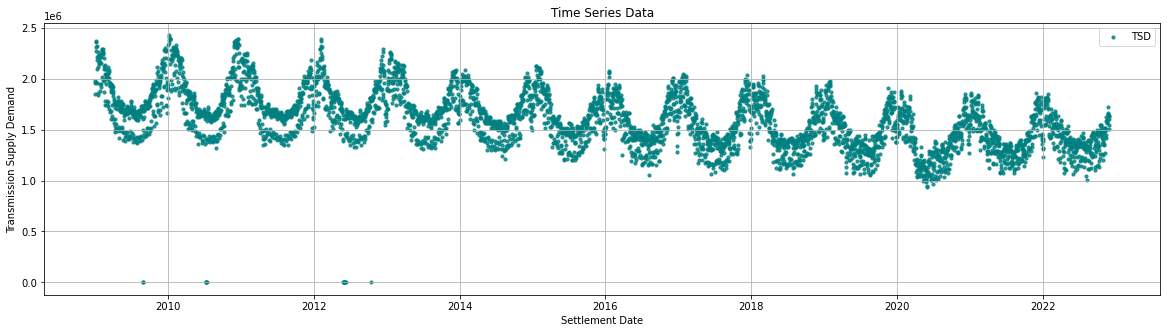

In [16]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.scatter(df_sarima.index,
           df_sarima['tsd'],
           marker = 'o',
           c = 'teal',
           s = 10,
           alpha=0.8,
           label="TSD"
           )

plt.title('Time Series Data')
plt.xlabel('Settlement Date')
plt.ylabel('Transmission Supply Demand')
plt.grid(True); plt.legend(); plt.show()

In [21]:
df.head()

,Unnamed: 0,period_hour,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag_1y,lag_2y,lag_3y
settlement_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,0,0:00:00,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 00:30:00,1,0:30:00,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 01:00:00,2,1:00:00,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 01:30:00,3,1:30:00,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 02:00:00,4,2:00:00,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1,1,3,1,1,1,2009,1,NaN,NaN,NaN


[Timestamp('2009-08-29 00:00:00'),
 Timestamp('2009-08-30 00:00:00'),
 Timestamp('2010-07-09 00:00:00'),
 Timestamp('2010-07-10 00:00:00'),
 Timestamp('2010-07-13 00:00:00'),
 Timestamp('2010-07-14 00:00:00'),
 Timestamp('2012-05-29 00:00:00'),
 Timestamp('2012-05-30 00:00:00'),
 Timestamp('2012-05-31 00:00:00'),
 Timestamp('2012-06-01 00:00:00'),
 Timestamp('2012-06-02 00:00:00'),
 Timestamp('2012-06-03 00:00:00'),
 Timestamp('2012-06-04 00:00:00'),
 Timestamp('2012-06-11 00:00:00'),
 Timestamp('2012-10-14 00:00:00')]

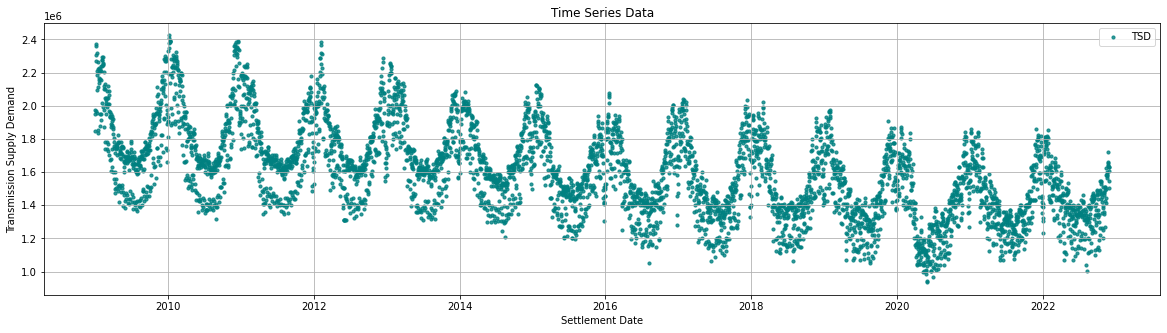

In [35]:
null_days = df_sarima[df_sarima['tsd'] == 0.0].index.unique().tolist()

null_info = zip(df_sarima.loc[null_days].index.month, 
                df_sarima.loc[null_days].index.year
               )

mean_values = [df_sarima.loc[(df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"].mean() for info in null_info ]

df_sarima.loc[null_days, "tsd"] = mean_values

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.scatter(df_sarima.index,
    df_sarima["tsd"],
    marker = 'o',
    c = 'teal',
    s = 10,
    alpha=0.8,
    label="TSD"
)

plt.title('Time Series Data')
plt.xlabel('Settlement Date')
plt.ylabel('Transmission Supply Demand')
plt.grid(True); plt.legend(); plt.show()

In [36]:
# Adding Lags and differences
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)

df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]
df_sarima.head(10)

,tsd,month,year,lag_day,lag_year,difference_day,difference_year
settlement_date,,,,,,,
2009-01-01,1849363.0,1,2009,NaN,NaN,NaN,NaN
2009-01-02,1974406.0,1,2009,1849363.0,NaN,125043.0,NaN
2009-01-03,1952054.0,1,2009,1974406.0,NaN,-22352.0,NaN
2009-01-04,1968670.0,1,2009,1952054.0,NaN,16616.0,NaN
2009-01-05,2271471.0,1,2009,1968670.0,NaN,302801.0,NaN
2009-01-06,2371755.0,1,2009,2271471.0,NaN,100284.0,NaN
2009-01-07,2360620.0,1,2009,2371755.0,NaN,-11135.0,NaN
2009-01-08,2305438.0,1,2009,2360620.0,NaN,-55182.0,NaN
2009-01-09,2318866.0,1,2009,2305438.0,NaN,13428.0,NaN


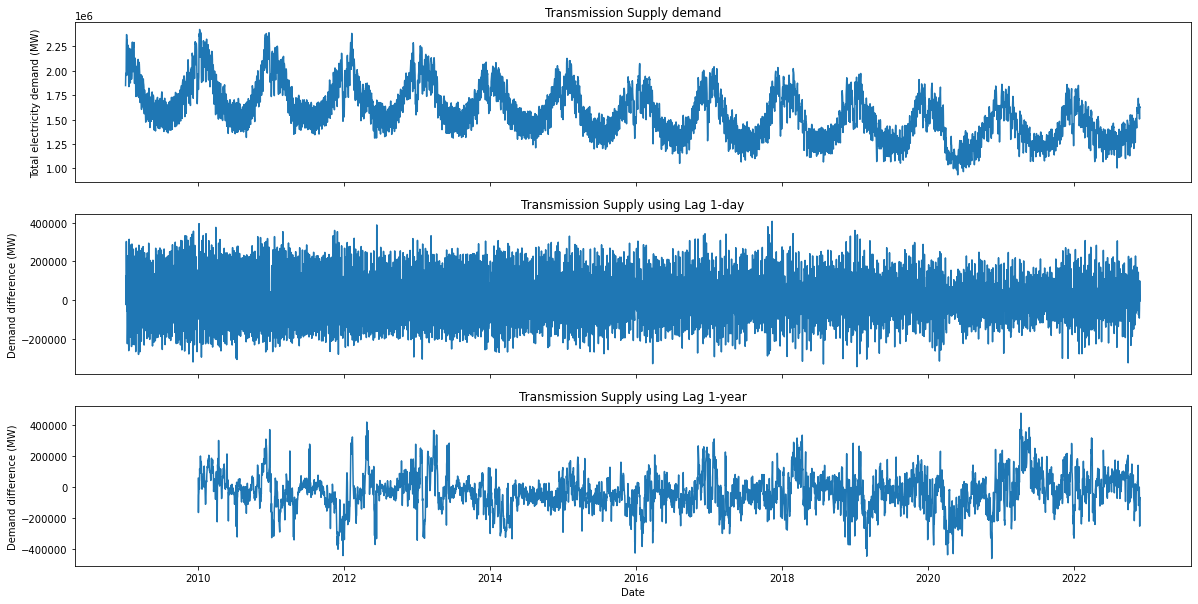

In [37]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Transmission Supply demand")

axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Transmission Supply using Lag 1-day")

axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Transmission Supply using Lag 1-year");

In [38]:
def checkStationarity(ts, window_size):
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(ts)
    print( 'T-Statistic          =', np.round( result[0],3) )
    print( 'p-value              =', np.round( result[1],3) )
    print( 'Lags Used            =', np.round( result[2]) )
    print( 'Observations Used    =', np.round( result[3]) )
    print( 'Critical Value (1%)  =', np.round( result[4]['1%'], 3) )
    print( 'Critical Value (5%)  =', np.round( result[4]['1%'], 3) )
    print( 'Critical Value (10%) =', np.round( result[4]['10%'], 3) )

    # Determing rolling statistics
    rolmean = ts.rolling(window=window_size).mean()
    rolstd = ts.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(20, 6))
    orig = plt.plot(ts, color="blue", alpha=0.95, label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.title("Rolling Mean and Standard Deviation")
    plt.legend(loc="best");plt.grid(True);plt.show(block=False)

T-Statistic          = -3.82
p-value              = 0.003
Lags Used            = 33
Observations Used    = 5048
Critical Value (1%)  = -3.432
Critical Value (5%)  = -3.432
Critical Value (10%) = -2.567


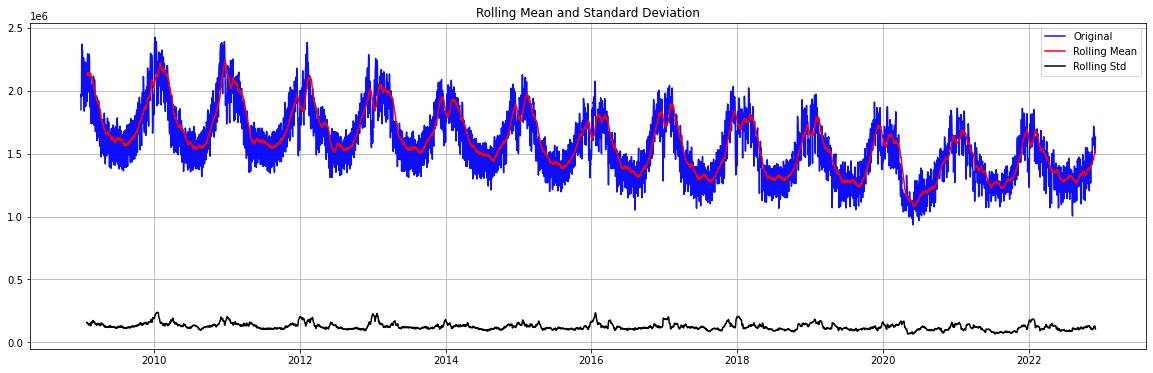

In [39]:
checkStationarity(ts= df_sarima['tsd'], 
                  window_size = 30)

T-Statistic          = -16.271
p-value              = 0.0
Lags Used            = 33
Observations Used    = 5047
Critical Value (1%)  = -3.432
Critical Value (5%)  = -3.432
Critical Value (10%) = -2.567


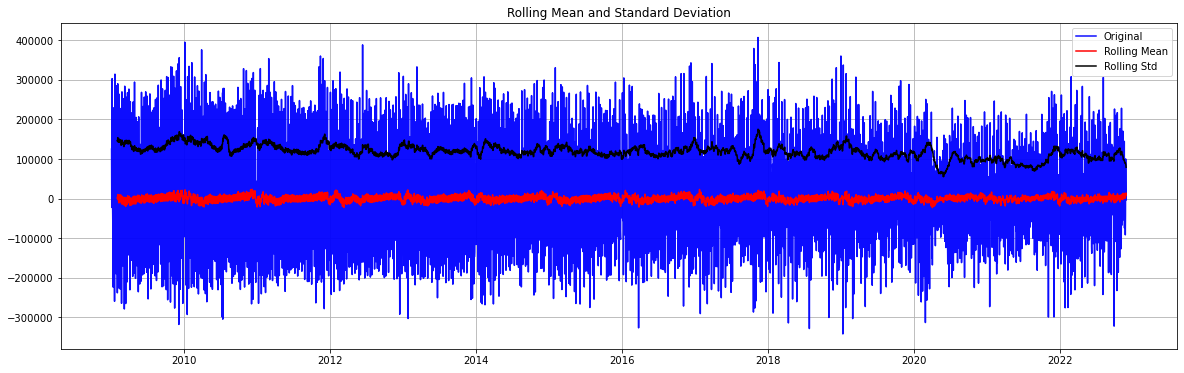

In [40]:
checkStationarity(ts= df_sarima['difference_day'].dropna(), 
                  window_size = 30)

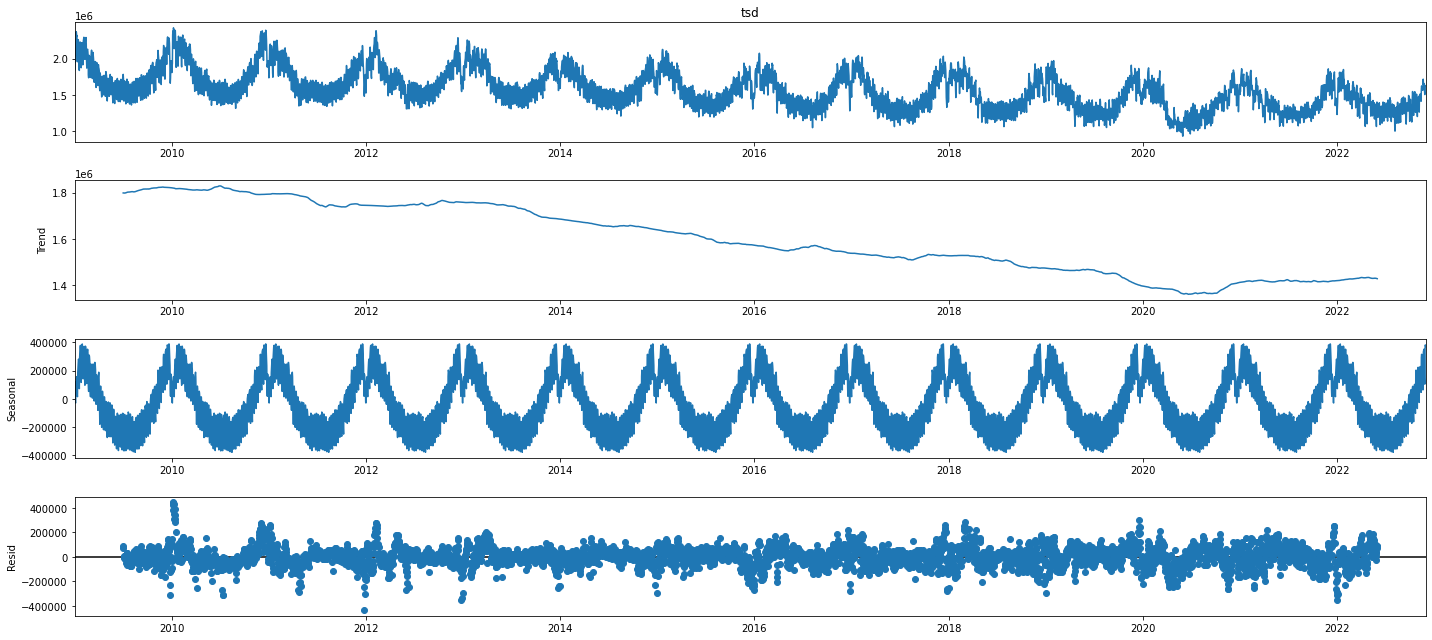

In [42]:
from statsmodels.tsa.api import seasonal_decompose
decompose = seasonal_decompose(df_sarima["tsd"].dropna(), 
                               period=364
                               )
fig = decompose.plot()
fig.set_size_inches((20, 9))
fig.tight_layout()

T-Statistic          = -4.819
p-value              = 0.0
Lags Used            = 33
Observations Used    = 5048
Critical Value (1%)  = -3.432
Critical Value (5%)  = -3.432
Critical Value (10%) = -2.567


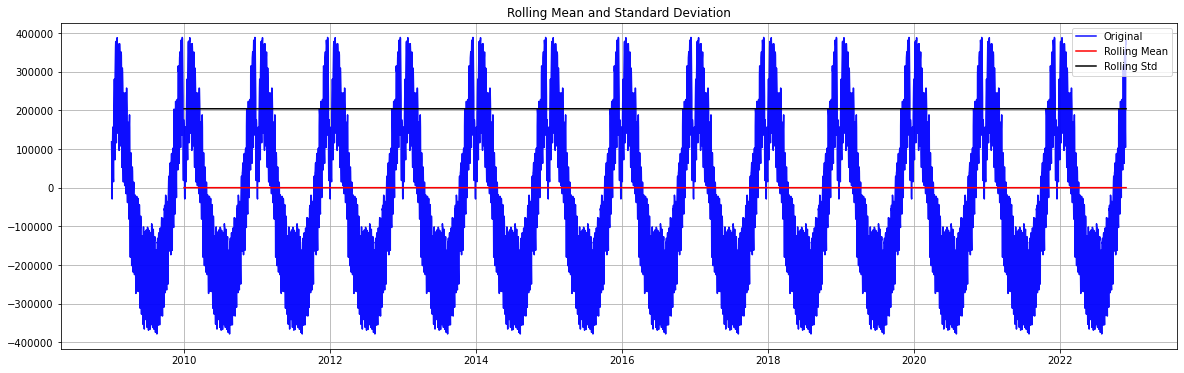

In [43]:
checkStationarity(decompose.seasonal, 364)

T-Statistic          = -8.498
p-value              = 0.0
Lags Used            = 21
Observations Used    = 4696
Critical Value (1%)  = -3.432
Critical Value (5%)  = -3.432
Critical Value (10%) = -2.567


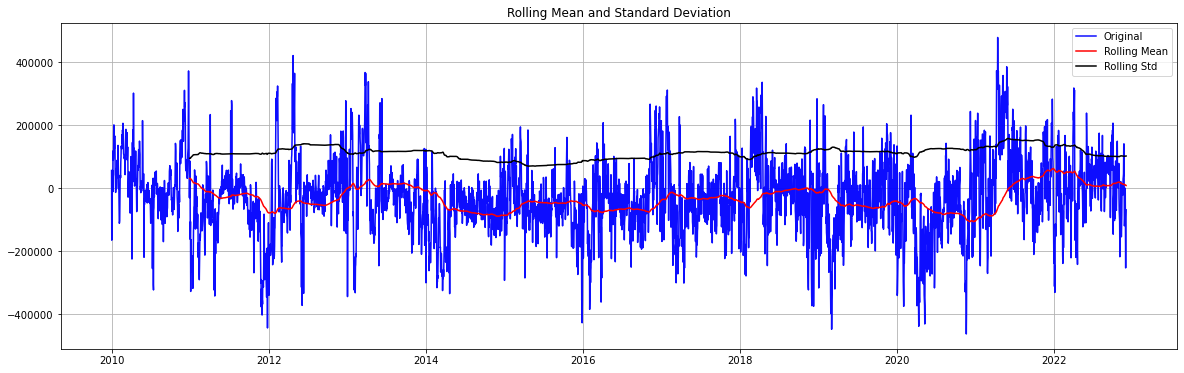

In [44]:
checkStationarity(df_sarima['difference_year'].dropna(), 364)

In [46]:
def acfpacfplots(ts, lags):    
    import statsmodels.api as sm
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(ts)
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=acf, zero=True)
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

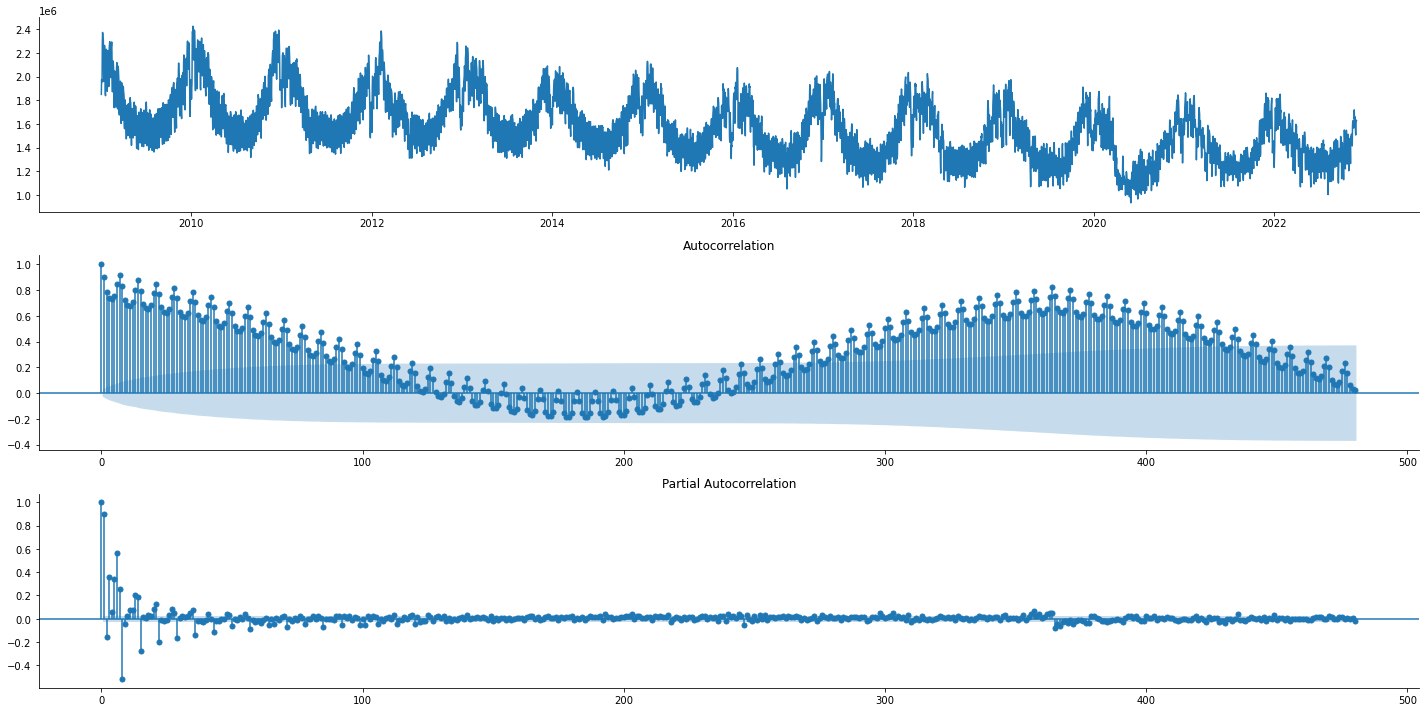

In [47]:
acfpacfplots(ts= df_sarima['tsd'], 
            lags = 480
            )

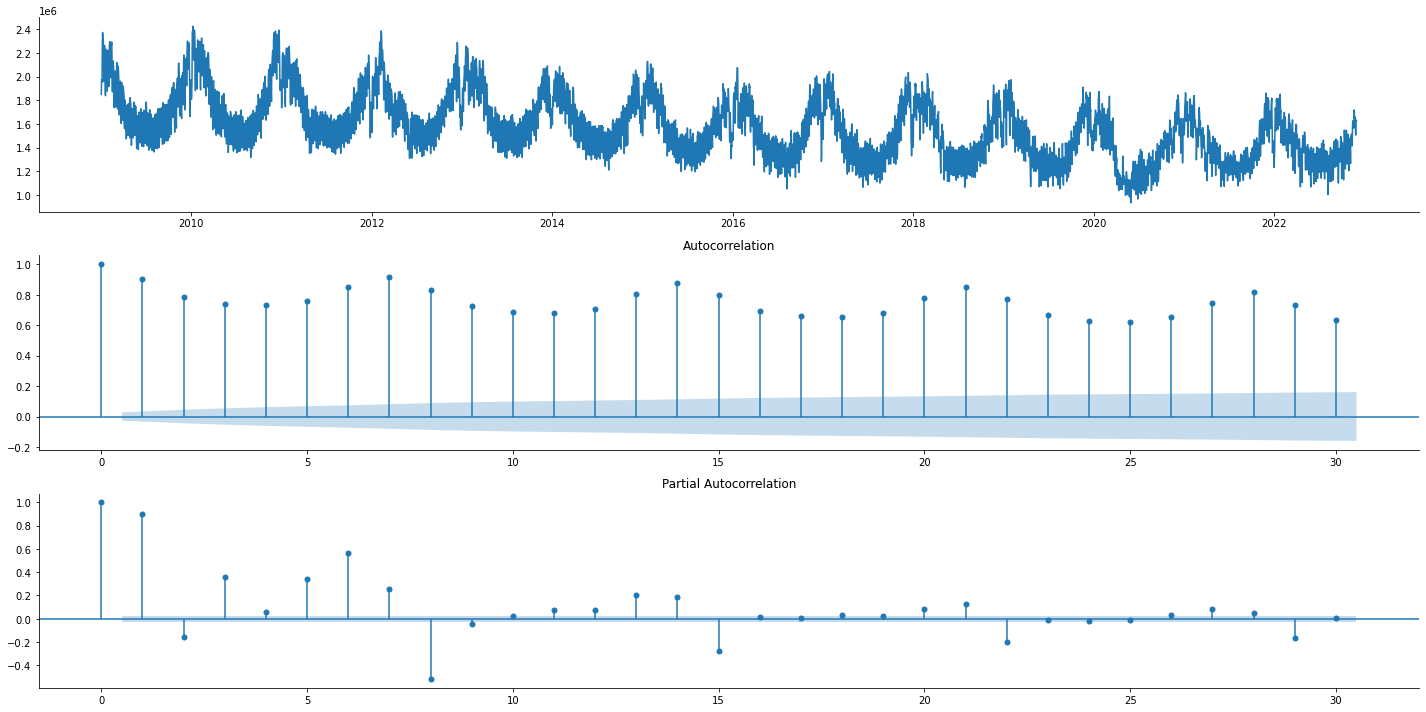

In [48]:
acfpacfplots(ts= df_sarima['tsd'], 
            lags = 30
            )

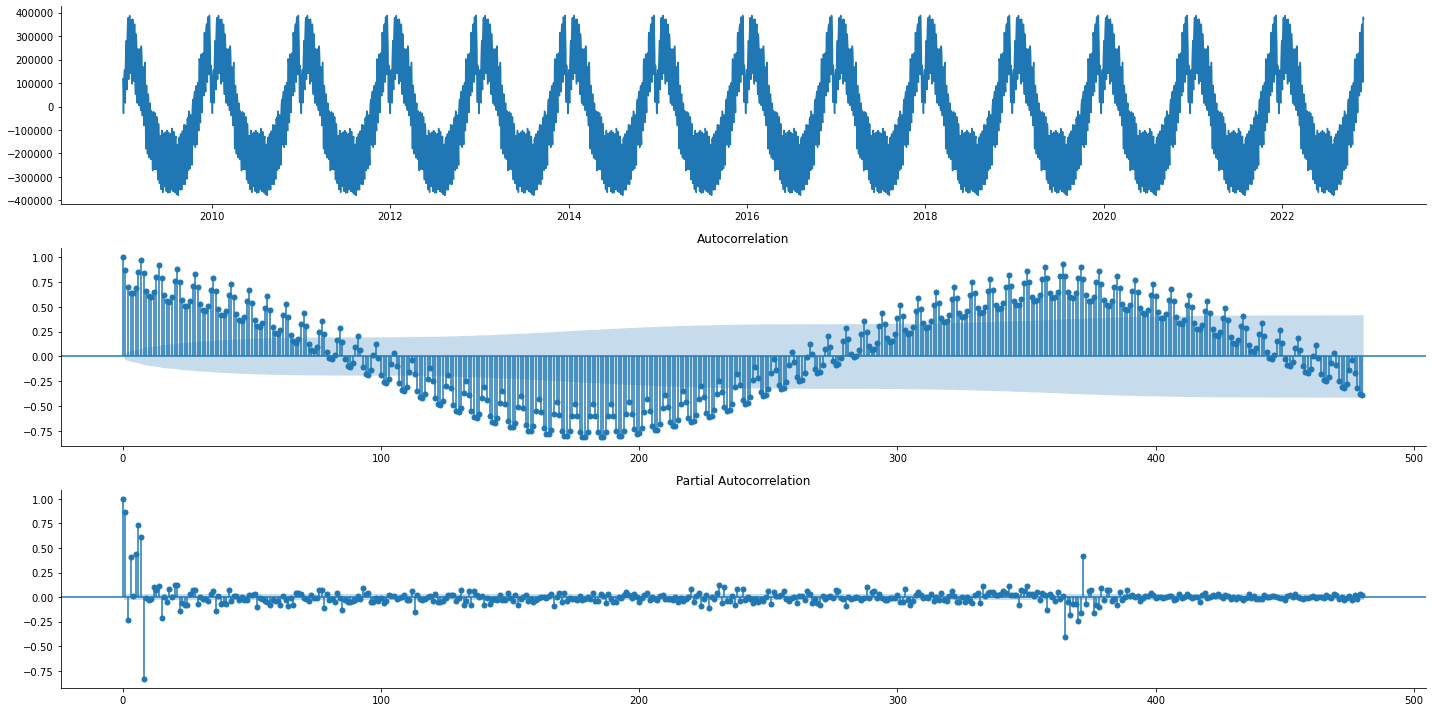

In [49]:
acfpacfplots(ts= decompose.seasonal, 
            lags = 480
            )

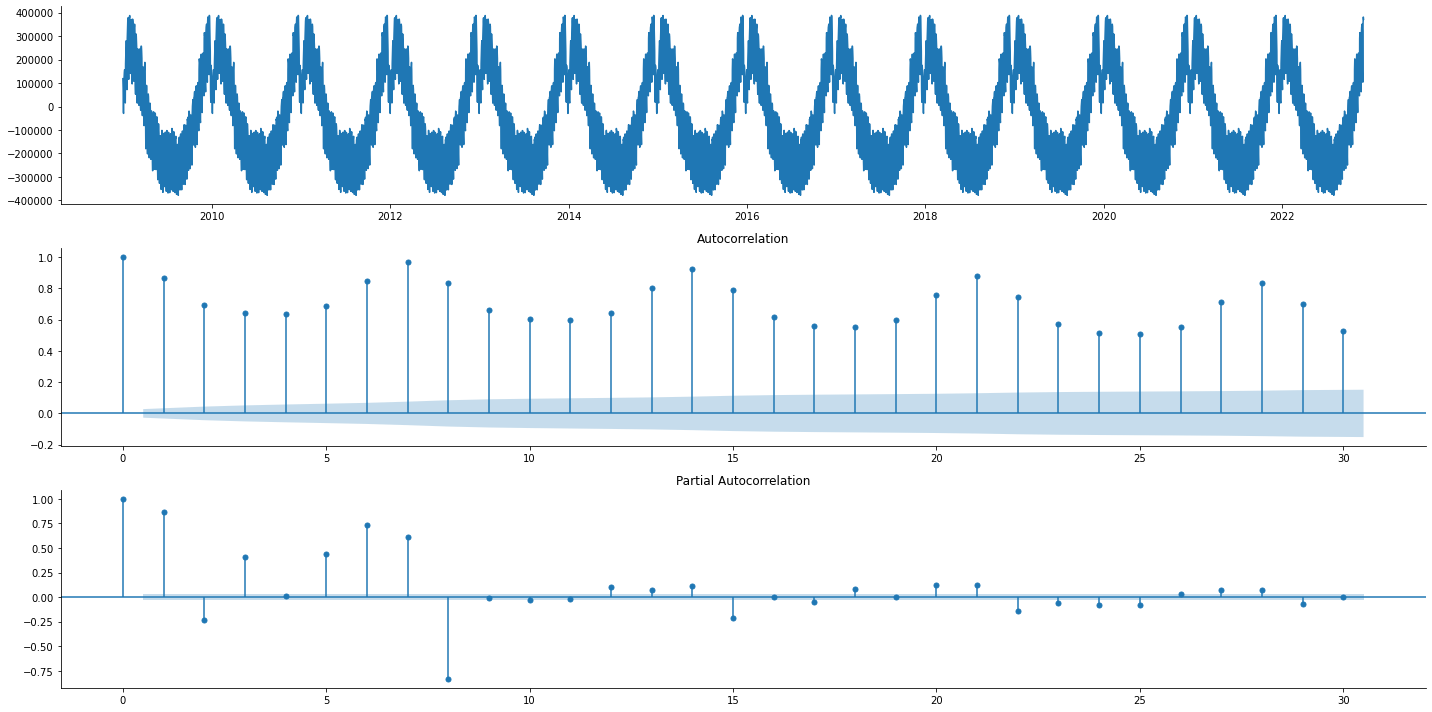

In [50]:
acfpacfplots(ts= decompose.seasonal, 
            lags = 30
            )

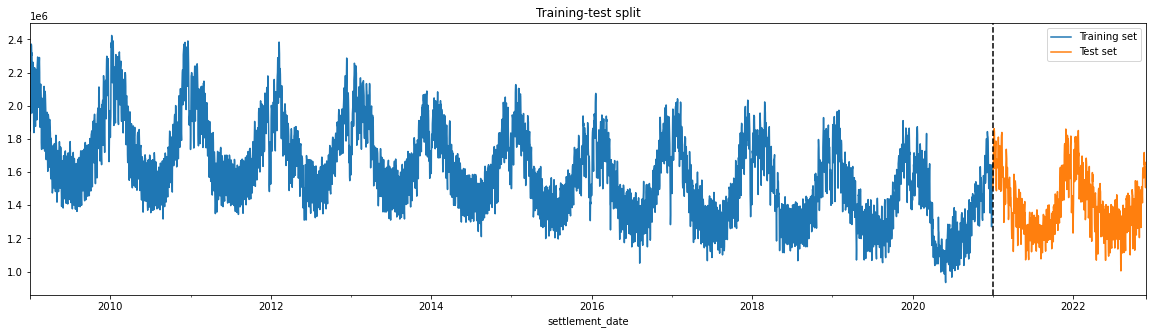

In [51]:
threshold_date = "01-01-2021"
data_train = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
data_test  = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

fig, ax = plt.subplots(figsize=(20, 5))
data_train.plot(ax=ax, label="Training set")
data_test.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

### SARIMA Models

In [360]:
def buildSarima(TA_TRAIN, TA_TEST, ORDER, SEASONAL_ORDER, MAX_ITER, LAGS, DISP_FLAG):
    # Create and fit SARIMA model
    import statsmodels.tsa.api as sm

    sarima_model = sm.statespace.SARIMAX(TA_TRAIN, 
                                        order=ORDER, 
                                        seasonal_order=SEASONAL_ORDER,
                                        ).fit(maxiter=MAX_ITER, disp=DISP_FLAG)

    # Model Diagnostics
    print( sarima_model.summary() );
    sarima_model.plot_diagnostics(lags=LAGS,
                                figsize=(20, 12),
                                );

                                # Prediction
    predict = sarima_model.get_prediction(start="01-01-2021", 
                                        end=str(TA_TEST.index[-1].date())
                                        );
    confidence_int = predict.conf_int(alpha=0.05);
    data_pred = predict.predicted_mean

    # Prediction
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data_pred, label="Prediction")
    ax.plot(TA_TEST, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    # Comparison Plot
    fig, ax = plt.subplots(figsize=(20, 5))
    data_train.plot(ax=ax, label="Training set")
    data_test.plot(ax=ax, label="Test set")
    data_pred.plot(ax=ax, label="Prediction")
    ax.axvline(threshold_date, color="k", ls="--")
    ax.set_title("Comparison Plot")
    plt.legend();

    # MAPE
    y_true, y_pred = np.array(TA_TEST), np.array(data_pred)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print( 'MAPE : ', np.round( MAPE, 3))

#### SARIMA Model 0 (Bench mark Case)

                                     SARIMAX Results                                      
Dep. Variable:                                tsd   No. Observations:                 4383
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -57029.520
Date:                            Wed, 04 Jan 2023   AIC                         114069.040
Time:                                    16:47:57   BIC                         114100.968
Sample:                                01-01-2009   HQIC                        114080.305
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.001   1520.216      0.000       0.998       1.001
ma.L1          0.0683      0.027   

c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


MAPE :  14.173400167420624


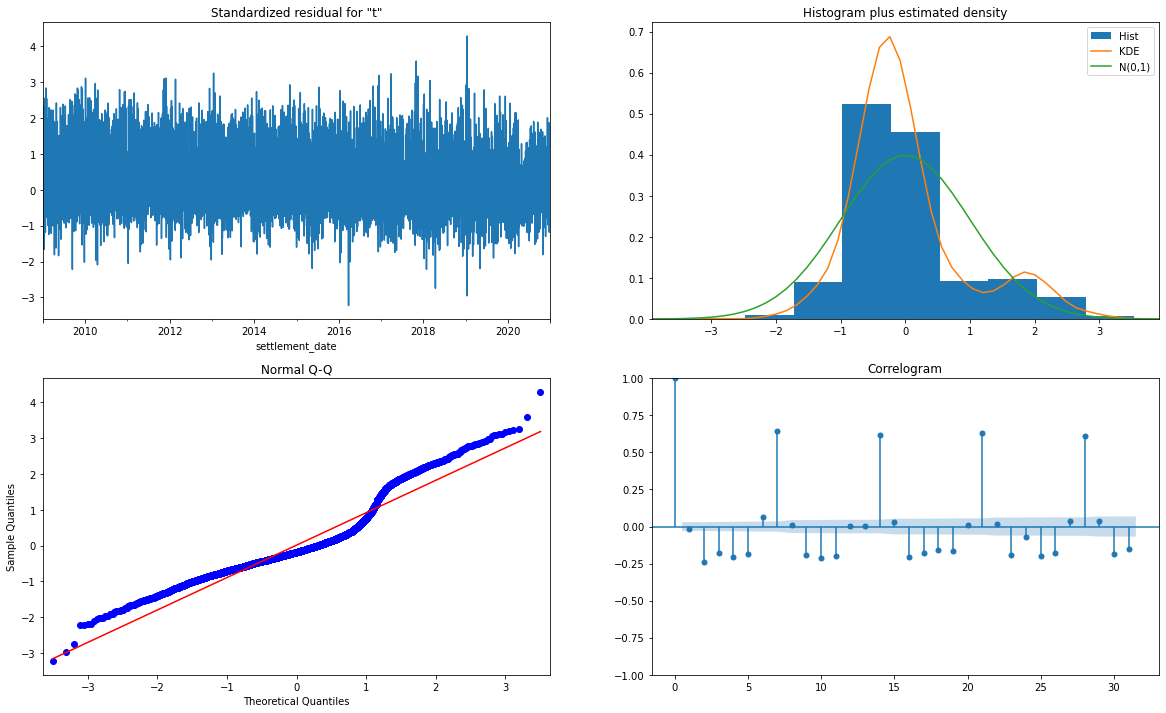

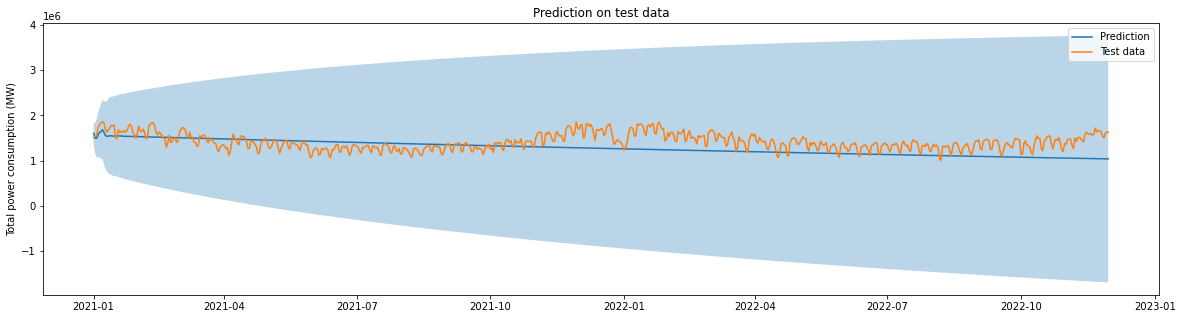

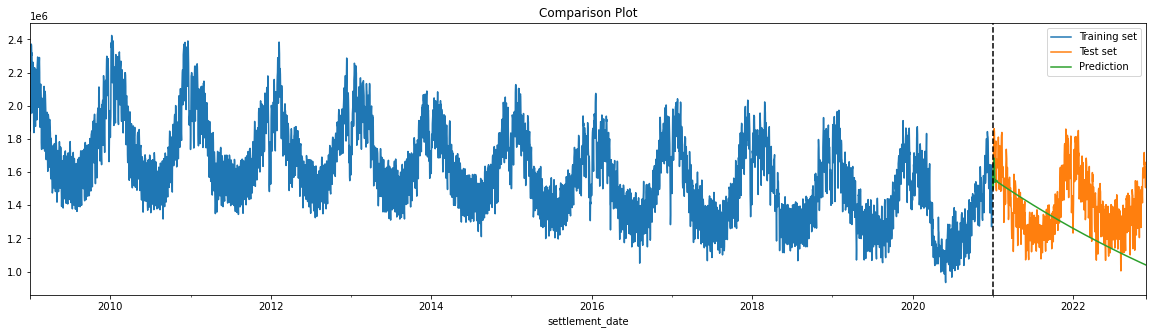

In [359]:
TA_TRAIN = data_train
TA_TEST = data_test
ORDER = (1,0,1)
SEASONAL_ORDER = (1,0,1,12)
MAX_ITER = 75
LAGS = 31
DISP_FLAG = False

buildSarima(TA_TRAIN, TA_TEST, ORDER, SEASONAL_ORDER, MAX_ITER, LAGS, DISP_FLAG)

####  SARIMA Model 1

c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                tsd   No. Observations:                 4383
Model:             SARIMAX(7, 1, 2)x(3, 1, 2, 12)   Log Likelihood              -55328.860
Date:                            Wed, 04 Jan 2023   AIC                         110687.721
Time:                                    17:05:31   BIC                         110783.459
Sample:                                01-01-2009   HQIC                        110721.505
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0367      0.037     -0.991      0.321      -0.109       0.036
ar.L2         -0.3349      0.034   

c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


MAPE :  18.814


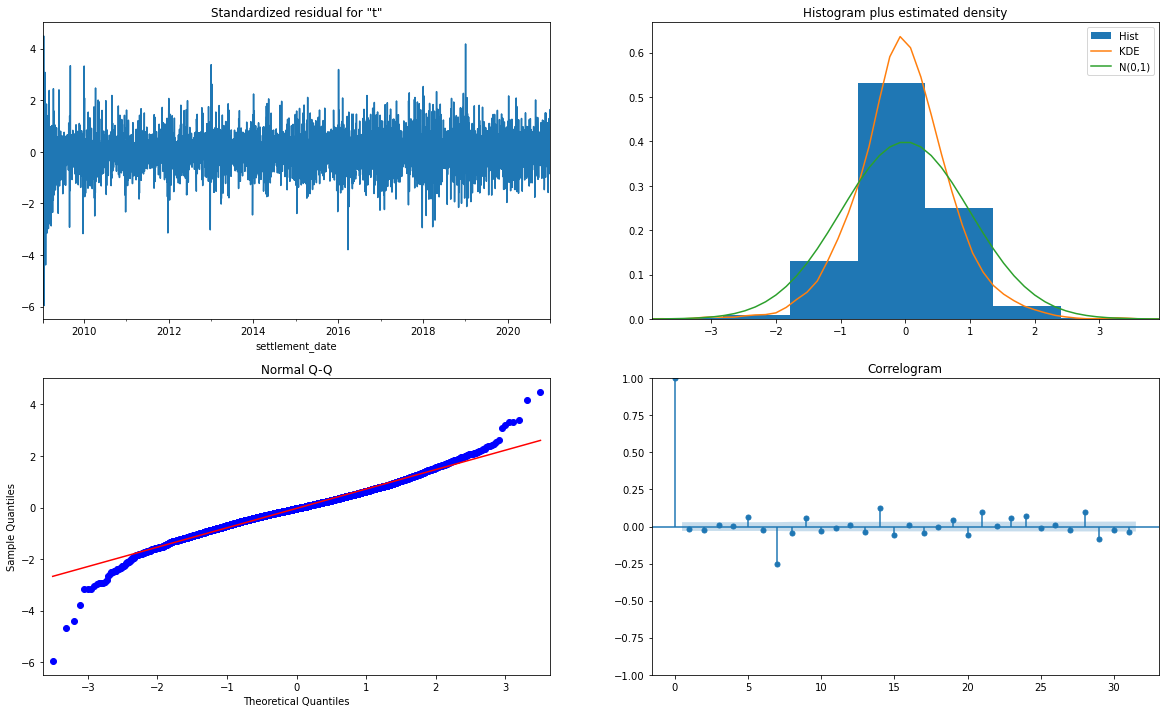

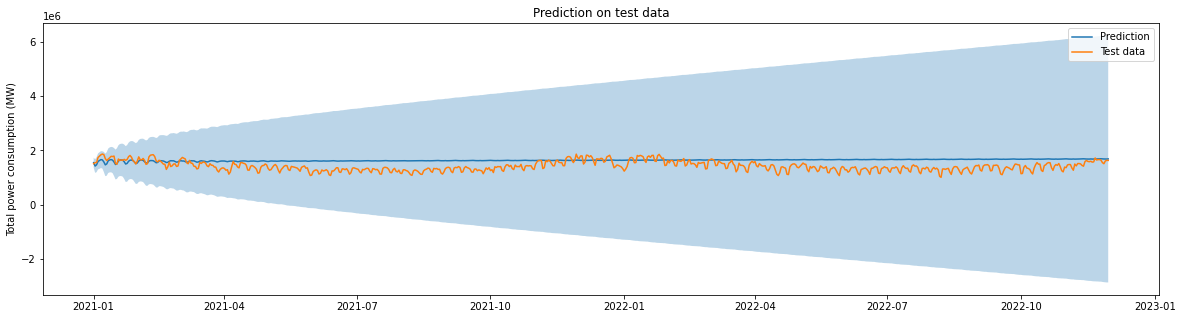

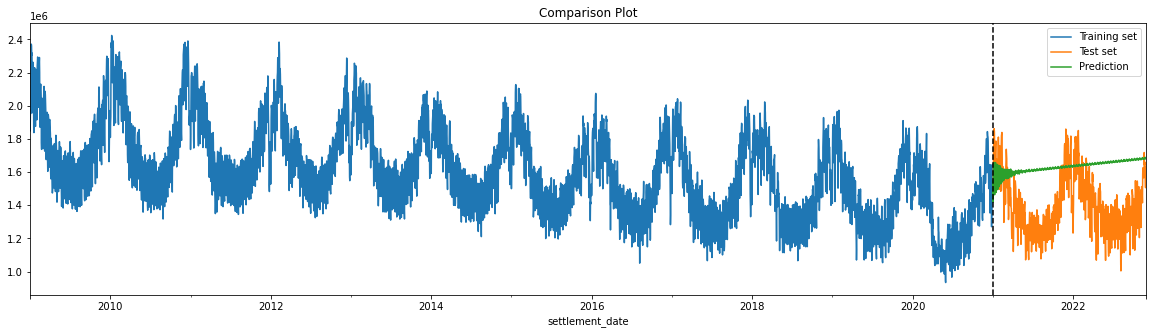

In [364]:
TA_TRAIN = data_train
TA_TEST = data_test
ORDER = (7,1,2)
SEASONAL_ORDER = (3,1,2,12)
MAX_ITER = 50   
LAGS = 31
DISP_FLAG = False

buildSarima(TA_TRAIN, TA_TEST, ORDER, SEASONAL_ORDER, MAX_ITER, LAGS, DISP_FLAG)

#### SARIMA Model 2

c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                     tsd   No. Observations:                 4383
Model:             SARIMAX(7, 1, 7)x(3, 1, [1, 2], 12)   Log Likelihood              -54986.640
Date:                                 Wed, 04 Jan 2023   AIC                         110013.279
Time:                                         17:19:15   BIC                         110140.930
Sample:                                     01-01-2009   HQIC                        110058.325
                                          - 12-31-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0468      0.054     -0.871      0.384      -0.152       0

c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


MAPE :  10.784


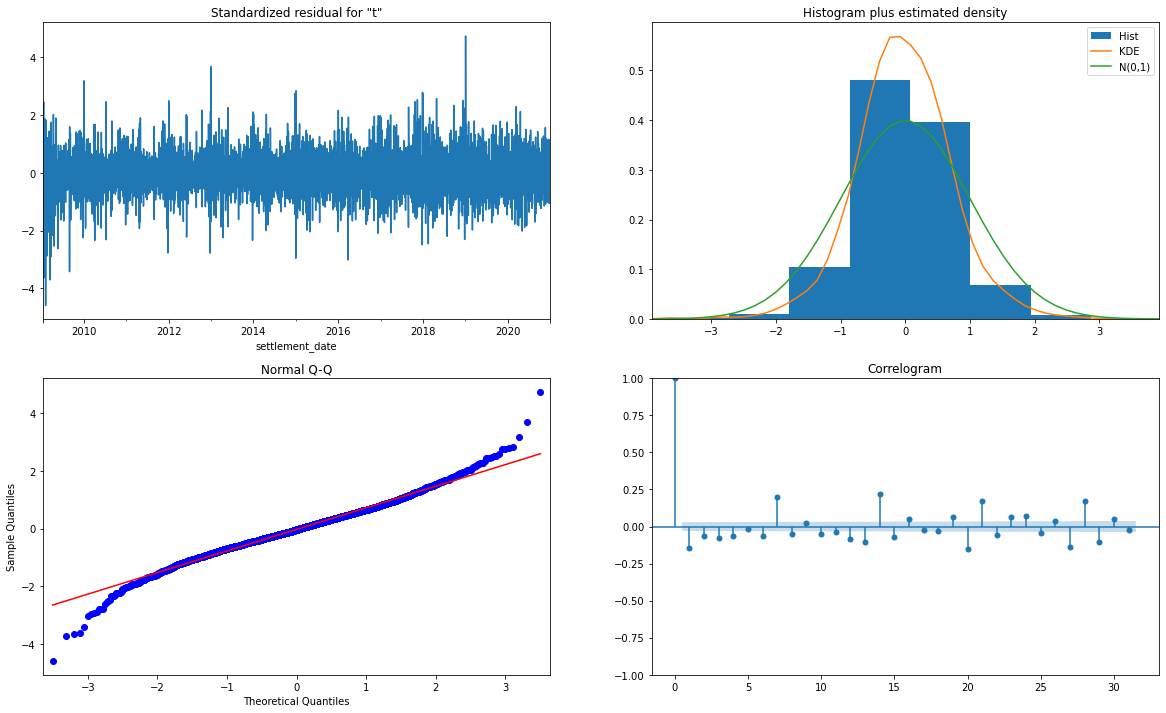

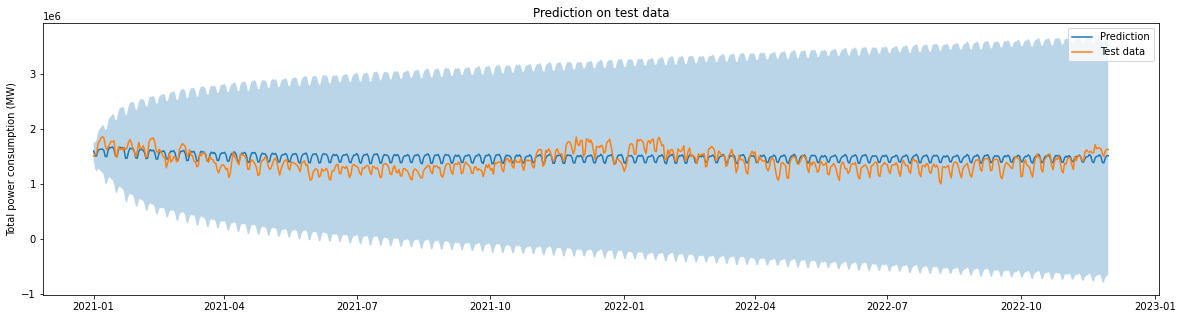

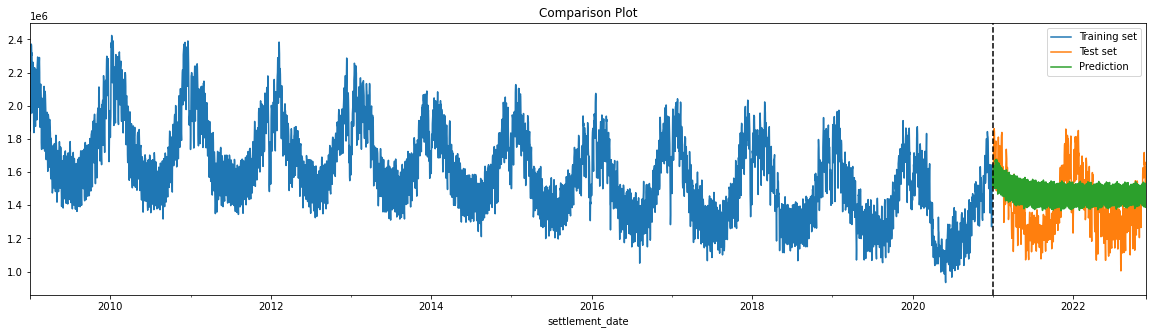

In [367]:
TA_TRAIN = data_train
TA_TEST = data_test
ORDER = (7,1,7)
SEASONAL_ORDER = (3,1,2,12)
MAX_ITER = 50   
LAGS = 31
DISP_FLAG = False

buildSarima(TA_TRAIN, TA_TEST, ORDER, SEASONAL_ORDER, MAX_ITER, LAGS, DISP_FLAG)

#### SARIMA Model 3

In [ ]:
TA_TRAIN = data_train
TA_TEST = data_test
ORDER = (7,1,7)
SEASONAL_ORDER = (9,1,2,12)
MAX_ITER = 25   
LAGS = 31
DISP_FLAG = True

buildSarima(TA_TRAIN, TA_TEST, ORDER, SEASONAL_ORDER, MAX_ITER, LAGS, DISP_FLAG)

#### Results for SARIMA Models

In [369]:
## Results

RESULTS_SARIMA = pd.DataFrame({ 'p': [1,7,7],
                                 'd': [0,1,1],
                                 'q': [1,2,7],
                                 'P': [1,3,3],
                                 'Q': [0,1,1],
                                 'D': [1,2,2],
                                 'M': [1,12,12],
                                 'LAGS':[31,31,31],
                                 'MAX_ITER':[75, 50, 50],
                                 'MAPE': [14.173, 18.814, 10.784],
                            })   

RESULTS_SARIMA

,p,d,q,P,Q,D,M,LAGS,MAX_ITER,MAPE
0,1,0,1,1,0,1,1,31,75,14.173
1,7,1,2,3,1,2,12,31,50,18.814
2,7,1,7,3,1,2,12,31,50,10.784


### Holt-Winters

In [58]:
def HoltWinter(TA_TRAIN, TA_TEST, SEASONAL_PERIODS, SEASONAL):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    HoltWinter = ExponentialSmoothing(TA_TRAIN,
                                    seasonal_periods=SEASONAL_PERIODS,
                                    seasonal=SEASONAL
                                            ).fit();

    data_pred = HoltWinter.forecast(len(TA_TEST));
    # Comparison Plot
    fig, ax = plt.subplots(figsize=(20, 5))
    data_train.plot(ax=ax, label="Training set")
    data_test.plot(ax=ax, label="Test set")
    data_pred.plot(ax=ax, label="Prediction")
    ax.axvline(threshold_date, color="k", ls="--")
    ax.set_title("Comparison Plot")
    plt.legend();

    # MAPE
    y_true, y_pred = np.array(TA_TEST), np.array(data_pred)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print( 'MAPE : ', np.round( MAPE, 3))

#### Simple Smoothing

c:\Users\ameya\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAPE :  18.324


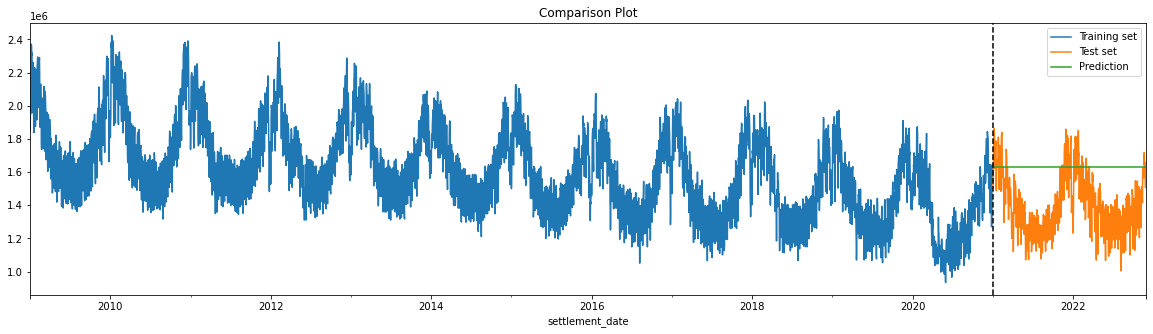

In [64]:
TA_TRAIN = data_train
TA_TEST = data_test
SEASONAL_PERIODS = 12*365 + 3
SEASONAL = None
holtWinter(TA_TRAIN, TA_TEST, SEASONAL_PERIODS, SEASONAL)

#### Exponential Seasonal = Additive

MAPE :  27.368


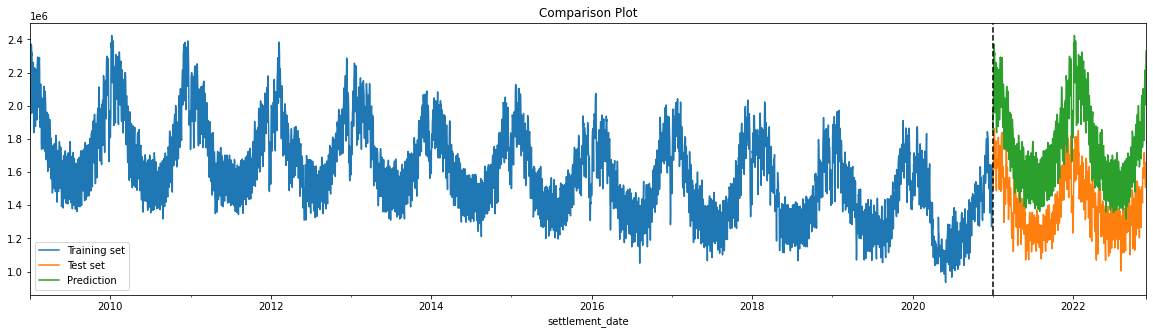

In [59]:
TA_TRAIN = data_train
TA_TEST = data_test
SEASONAL_PERIODS = 12*365 + 3
SEASONAL = 'add'
HoltWinter(TA_TRAIN, TA_TEST, SEASONAL_PERIODS, SEASONAL)

### Prophet

19:44:53 - cmdstanpy - INFO - Chain [1] start processing
19:44:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE :  10.632


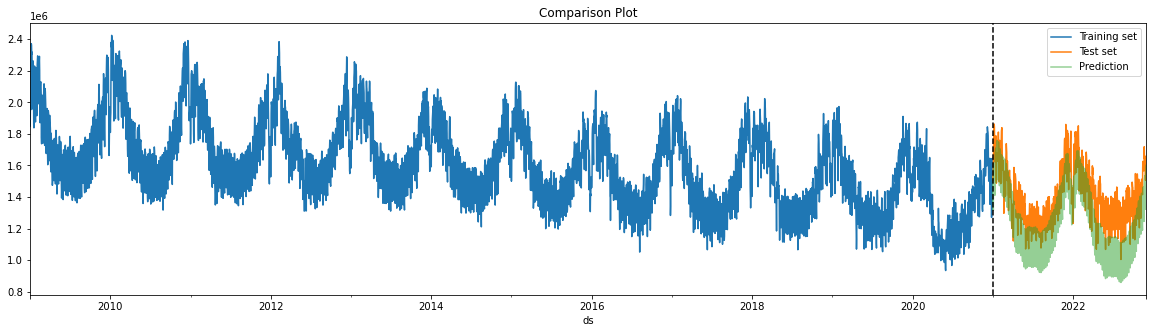

In [115]:
# Modifying columns names
data_train_p = pd.DataFrame({'ds' : data_train.index, 'y' : data_train}).reset_index()
data_train_p = data_train_p.drop(['settlement_date'], axis=1)
data_test_p = pd.DataFrame({'ds' : data_test.index, 'y' : data_test}).reset_index()
data_test_p = data_test_p.drop(['settlement_date'], axis=1)

from prophet import Prophet
modelProphet = Prophet()
modelProphet.fit (data_train_p)

data_test_p = data_test_p.drop(['y'], axis=1)
data_pred = modelProphet.predict(data_test_p)
data_pred.set_index('ds', inplace=True)

# Comparison Plot
fig, ax = plt.subplots(figsize=(20, 5))
data_train.plot(ax=ax, label="Training set")
data_test.plot(ax=ax, label="Test set")
data_pred['yhat'].plot(ax=ax, label="Prediction", alpha=0.5)
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Comparison Plot")
plt.legend();

# MAPE
y_true, y_pred = np.array(TA_TEST), np.array(data_pred['yhat'])
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print( 'MAPE : ', np.round( MAPE, 3))

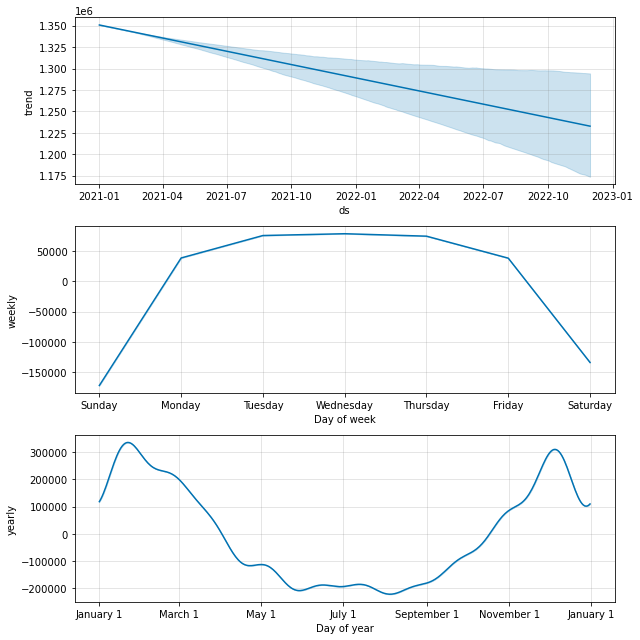

In [113]:
_ = modelProphet.plot_components(data_pred.reset_index())

### XgBoost Model